GoingDeeper 2. Augmentation with Cutmix_Mixup
---------------------------

## 0-1 모듈 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 0-2. 데이터 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


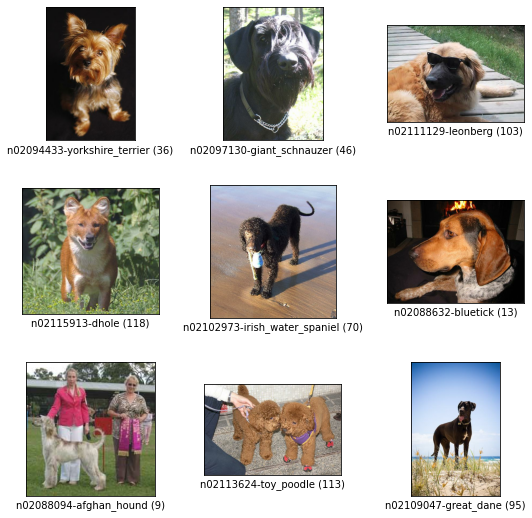

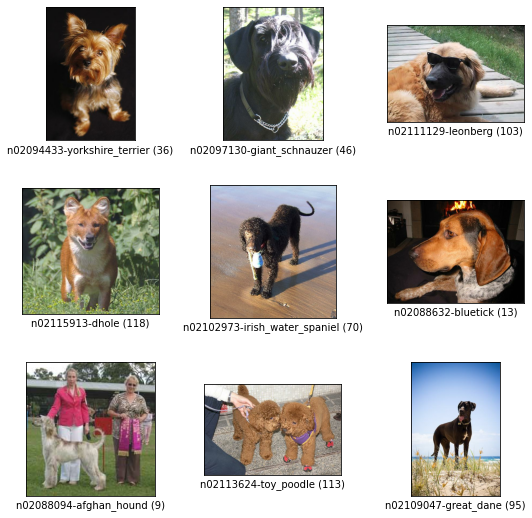

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
BATCH_SIZE = 32
num_classes = ds_info.features["label"].num_classes

## 1. 함수 정의

### 전처리

In [6]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=BATCH_SIZE, with_aug=False, with_cutmix=False,with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


### Cut-Mix Augmentation

In [7]:
def get_clip_box(image_a,image_b):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    x = tf.cast(tf.random.uniform([],0,image_size_x),tf.int32)
    y = tf.cast(tf.random.uniform([],0,image_size_y),tf.int32)

    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)

    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)

    return x_min,y_min,x_max,y_max

In [8]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [9]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [10]:
def cutmix(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a,label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### MIX-UP Augmentation

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b,num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [12]:
def mixup(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b,num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [13]:
def onehot(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=224, num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        label_a = tf.one_hot(label[i], num_classes)
        imgs.append(image[i])
        labels.append(label_a)

    imgs = tf.reshape(tf.stack(imgs), (batch_size, img_size, img_size, 3))
    labels = tf.reshape(tf.stack(labels), (batch_size, num_classes))
    return imgs, labels

## 2. 모델 정의 및 훈련

In [14]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'avg',
    ),
    keras.layers.Dense(num_classes,activation='softmax')
])

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes,activation='softmax')
])

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes,activation='softmax')
])

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes,activation='softmax')
])

94773248/94765736 [==============================] - 1s 0us/step


In [15]:
(ds_train,ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train,with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,batch_size=BATCH_SIZE,with_aug=True,with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,batch_size=BATCH_SIZE,with_aug=True,with_cutmix=True)
ds_test = apply_normalize_on_dataset(ds_test,is_test=True)

In [21]:
EPOCH = 5

resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

cutmix_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

mixup_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True

)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps = int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True

)

Epoch 1/5
375/375 [==============================] - 307s 780ms/step - loss: 0.9265 - accuracy: 0.7630 - val_loss: 3.3329 - val_accuracy: 0.2266
Epoch 2/5
375/375 [==============================] - 325s 866ms/step - loss: 0.5111 - accuracy: 0.8810 - val_loss: 1.0657 - val_accuracy: 0.6909
Epoch 3/5
375/375 [==============================] - 288s 768ms/step - loss: 0.2372 - accuracy: 0.9555 - val_loss: 0.9329 - val_accuracy: 0.7205
Epoch 4/5
375/375 [==============================] - 287s 765ms/step - loss: 0.0972 - accuracy: 0.9897 - val_loss: 0.9274 - val_accuracy: 0.7247
Epoch 5/5
375/375 [==============================] - 289s 772ms/step - loss: 0.0503 - accuracy: 0.9980 - val_loss: 0.9252 - val_accuracy: 0.7319
Epoch 1/5
375/375 [==============================] - 303s 772ms/step - loss: 1.0982 - accuracy: 0.7114 - val_loss: 3.0095 - val_accuracy: 0.2585
Epoch 2/5
375/375 [==============================] - 289s 772ms/step - loss: 0.7265 - accuracy: 0.8041 - val_loss: 1.1334 - val_ac

## 3. 모델 성능 시각화

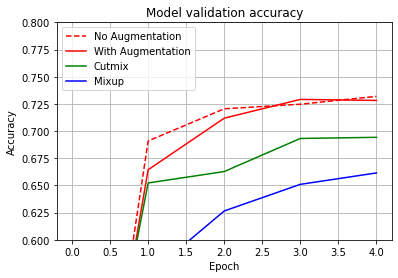

In [24]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r--')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','Cutmix',"Mixup"], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

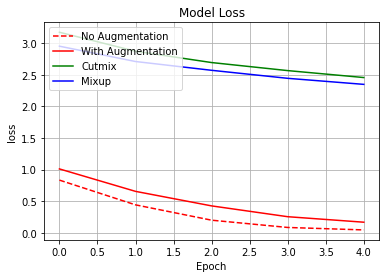

In [36]:
plt.plot(history_resnet50_no_aug.history['loss'], 'r--')
plt.plot(history_resnet50_aug.history['loss'], 'r')
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_mixup.history['loss'], 'b')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','Cutmix',"Mixup"], loc='upper left')
plt.grid(True)
plt.show()

### 회고
- 코드가 정말 더러워서 하다가도 화가 많이 났던 노드였습니다. 왜 이렇게 코드를 짰는지 모르겠네요. 검증도 테스트도 안하고 노드를 만드는건 아닌것같은데..
- 시각화 결과를 보면 Cutmix,Mixup이 오히려 더 안좋게 나오는데 데이터수가 증가해서 그런 것 같습니다 Epoch를 50까지 올려야만 효과를 볼 수 있을 것 같은데 시간이 없습니다.
- 다양한 Augmentation에 방법을 알게 되어 데이터수가 부족해도 데이터를 늘릴 방법을 알게되어 도움이 많이 된 것 같습니다.